In [1]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 4.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import zipfile
import os
import mne
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [87]:
electrodos_1020 = ['Fpz', 'Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                   'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Cz', 'Pz', 'A1', 'A2', 'Oz']

# Obtén las coordenadas de los electrodos
montaje = mne.channels.make_standard_montage('standard_1020')
posiciones = montaje.get_positions()['ch_pos']
nombres_electrodos = list(posiciones.keys())
nombres_electrodos_filtrados = [nombre for nombre in nombres_electrodos if nombre in electrodos_1020]

frecuencia_muestreo = 1000 # Hz

In [76]:
info = mne.create_info(ch_names=nombres_electrodos_filtrados, sfreq=frecuencia_muestreo, ch_types='eeg')

In [7]:
%cd drive/MyDrive/Tesis/

/content/drive/MyDrive/Tesis


In [55]:
# Convierto data a microvoltios
data_felicidad = np.transpose(np.load('Felicidad/raw_felicidad.npy'), (2, 0, 1)) * 10 **(-6)
data_tristeza = np.transpose(np.load('Tristeza/raw_tristeza.npy'), (2, 0, 1)) * 10 **(-6)
data_miedo = np.transpose(np.load('Miedo/raw_miedo.npy'), (2, 0, 1)) * 10 **(-6)
data_desagrado = np.transpose(np.load('Desagrado/raw_desagrado.npy'), (2, 0, 1)) * 10 **(-6)
data_neutral = np.transpose(np.load('Neutral/raw_neutral.npy'), (2, 0, 1)) * 10 **(-6)

epochs_felicidad = mne.EpochsArray(data_felicidad, info)
epochs_tristeza = mne.EpochsArray(data_tristeza, info)
epochs_miedo = mne.EpochsArray(data_miedo, info)
epochs_desagrado = mne.EpochsArray(data_desagrado, info)
epochs_neutral = mne.EpochsArray(data_neutral, info)

Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated


In [24]:
epochs_felicidad.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,23 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


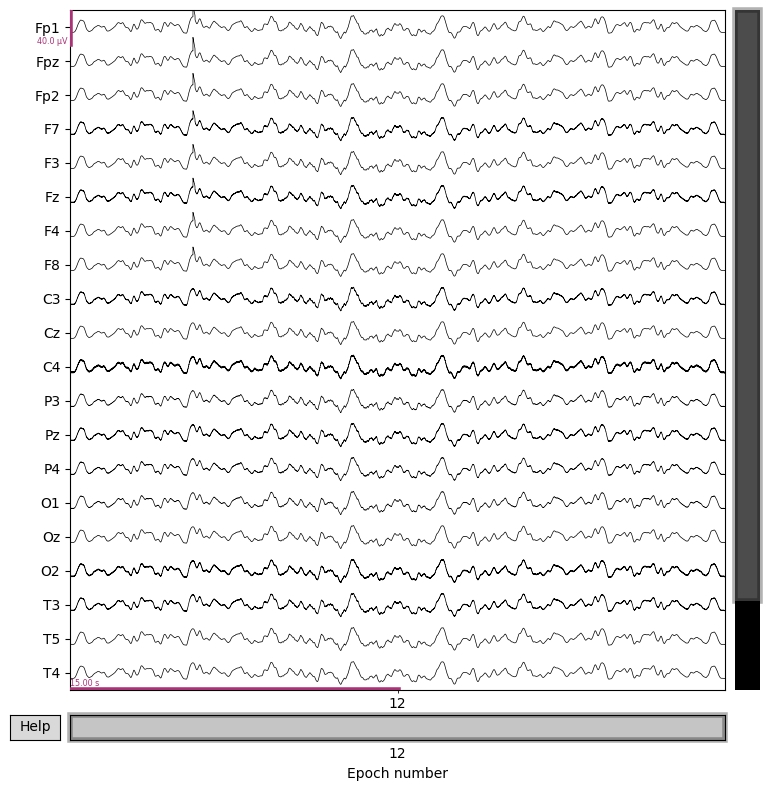

In [21]:
epochs_felicidad[12].plot();

In [60]:
epochs_felicidad.get_data().shape

<ipython-input-60-8a76b5a166b5>:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_felicidad.get_data().shape


(25, 23, 30000)

# Filtrado de señales

In [58]:
from scipy import signal

In [71]:
def notch_epochs(epochs, freq_notch=50, ch_names=nombres_electrodos_filtrados, sfreq=frecuencia_muestreo) -> mne.EpochsArray:
  """Apply notch filter over epochs"""
  data = epochs.get_data()
  data_notched = np.empty_like(data)

  for i in range(data.shape[0]):
    data_notched[i] = mne.filter.notch_filter(data[i], Fs=frecuencia_muestreo, freqs=freq_notch)

  info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

  epochs_notched = mne.EpochsArray(data_notched, info)

  return epochs_notched

In [ ]:
epochs_tristeza.filter(l_freq=0.5, h_freq=60)
epochs_tristeza = notch_epochs(epochs_tristeza)


epochs_felicidad.filter(l_freq=0.5, h_freq=60)
epochs_felicidad = notch_epochs(epochs_felicidad)

epochs_miedo.filter(l_freq=0.5, h_freq=60)
epochs_miedo = notch_epochs(epochs_miedo)

epochs_desagrado.filter(l_freq=0.5, h_freq=60)
epochs_desagrado = notch_epochs(epochs_desagrado)

epochs_neutral.filter(l_freq=0.5, h_freq=60)
epochs_neutral = notch_epochs(epochs_neutral)

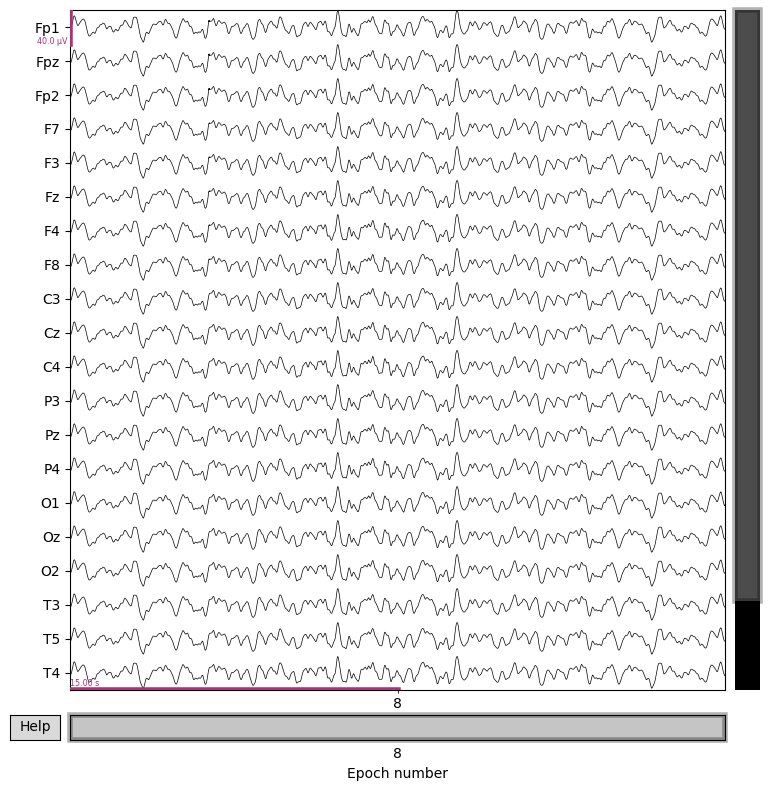

In [68]:
epochs_tristeza[8].plot();

# Montaje de electrodos

<ipython-input-102-bb453d564f5e>:11: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  montaje_personalizado.plot();


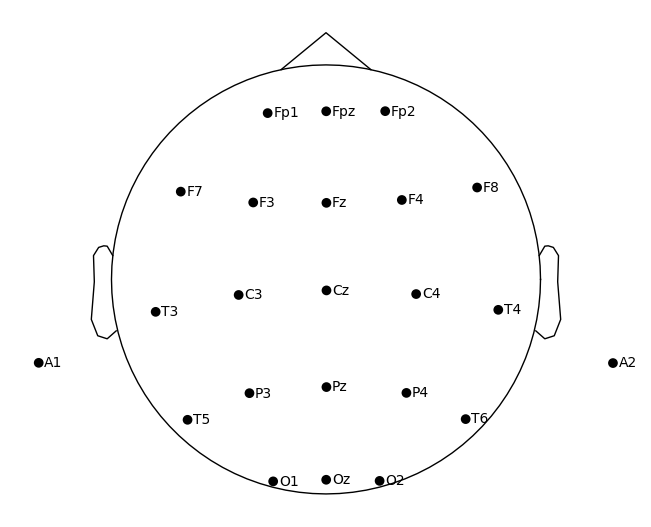

In [102]:
# Define los nombres de los electrodos según el estándar 10-20 que estás utilizando
# electrodos_1020 = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

# Filtra las posiciones de los electrodos para incluir solo los que estás utilizando
posiciones_filtradas = {nombre: montaje.get_positions()['ch_pos'][nombre]/1.2 for nombre in electrodos_1020 if nombre in montaje.get_positions()['ch_pos']}

# Crea un montaje personalizado con los electrodos filtrados
montaje_personalizado = mne.channels.make_dig_montage(ch_pos=posiciones_filtradas)

# Muestra el montaje de los electrodos filtrados
montaje_personalizado.plot();

In [108]:
montaje_personalizado

<DigMontage | 0 extras (headshape), 0 HPIs, 0 fiducials, 23 channels>

# Guardar datos preprocesados

In [105]:
epochs_neutral.save('Neutral/preprocessed_neutral.fif', overwrite=True)
epochs_felicidad.save('Felicidad/preprocessed_felicidad.fif', overwrite=True)
epochs_tristeza.save('Tristeza/preprocessed_tristeza.fif', overwrite=True)
epochs_desagrado.save('Desagrado/preprocessed_desagrado.fif', overwrite=True)
epochs_miedo.save('Miedo/preprocessed_miedo.fif', overwrite=True)

<ipython-input-105-041f8b05d66e>:1: RuntimeWarning: This filename (Neutral/preprocessed_neutral.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_neutral.save('Neutral/preprocessed_neutral.fif', overwrite=True)
<ipython-input-105-041f8b05d66e>:2: RuntimeWarning: This filename (Felicidad/preprocessed_felicidad.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_felicidad.save('Felicidad/preprocessed_felicidad.fif', overwrite=True)
<ipython-input-105-041f8b05d66e>:3: RuntimeWarning: This filename (Tristeza/preprocessed_tristeza.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_tristeza.save('Tristeza/preprocessed_tristeza.fif', overwrite=True)
<ipython-input-105-041f8b05d66e>:4: RuntimeWarning: This filename (Desagrado/preprocesse